## TSP Miller–Tucker–Zemlin (MTZ) callbacks formulation

$ \text{Variables} $

$x_{ij}={\begin{cases}1&{\text{the path goes from city }}i{\text{ to city }}j\\0&{\text{otherwise}}\end{cases}}$

$u_{i}=\text{keeps track of the order in which the cities are visited, counting from city 1 the interpretation is that $u_{i}$ < $u_{j}$ implies city i is visited before city j} $

\begin{equation*}
\begin{aligned}
& \underset{}{\text{minimize}}
& & \sum_{i=1}^{n} \sum_{j=1, j\neq i}^{n} c_{ij} x_{ij} \\
& \text{subject to}
& & \sum_{j=1, j\neq i}^{n} x_{ij} = 1, \quad i = 1,\ldots,n, \\
& 
& & \sum_{i=1, i\neq j}^{n} x_{ij} = 1, \quad j = 1,\ldots,n, \\
& 
& & u_{i} - u_{j} + n x_{ij} \leq n - 1, \quad 2 \leq i \neq j \leq n.\\
&
& & x_{ij} \in \{0,1\}, \quad i,j = 1,\ldots,n, \, i\neq j, \\
&
& & u_{i} \in \mathbf {Z}, \quad i=2,\ldots ,n.
\end{aligned}
\end{equation*}


In [1]:
########################################## Import library and model enviroment ############################################

from docplex.mp.model import Model
import numpy as np
import networkx as nx   
import matplotlib.pyplot as plt


mdl=Model('modelo')

In [2]:
def graphic(x,d,N):
    edges = []
    for i in N:
        for j in N:
            if i != j and x[i,j] > 0.5: # Este es un valor de tolerancia, puede ajustarse según la necesidad
                edges.append((i, j, d[i-1][j-1]))
    # Crear un grafo de NetworkX
    G = nx.Graph()
    for edge in edges:
        G.add_edge(edge[0], edge[1], weight=edge[2])

    plt.figure(figsize=(10, 10))
    # Dibujar el grafo
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    # Mostrar el gráfico
    plt.show()

In [3]:
#Create a Random Matrix
C = np.random.randint(1, 100, size=(100, 100))
# A_i,i = 0
np.fill_diagonal(C, 0)

In [4]:
#Parameters
n=len(C)

In [5]:
#Sets
N=[i+1 for i in range(n)]

In [6]:
print(N)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [7]:
#Index
Ind={(i,j) for i in N for j in N if i!=j}
Ind2={(i) for i in N if i!=1}

In [8]:
#Variables
x=mdl.binary_var_dict(Ind, name='x')
u=mdl.integer_var_dict(Ind2, name='u')

In [9]:
#Callbacks lazycuts

from cplex.callbacks import LazyConstraintCallback
from docplex.mp.callbacks.cb_mixin import *
from docplex.mp.model import Model

class CustomLazyCallback(ConstraintCallbackMixin, LazyConstraintCallback):

    def __init__(self, env):
        LazyConstraintCallback.__init__(self, env)
        ConstraintCallbackMixin.__init__(self)
        self.nb_lazy_cts = 0

    def add_lazy_constraints(self, cts):
        self.register_constraints(cts)

    @print_called('--> lazy constraint callback called: #{0}')
    def __call__(self):
        sol = self.make_solution()
        unsats = self.get_cpx_unsatisfied_cts(self.cts, sol, tolerance=1e-6)
        for ct, cpx_lhs, sense, cpx_rhs in unsats:
            self.add(cpx_lhs, sense, cpx_rhs)
            self.nb_lazy_cts += 1
            print('  -- new lazy constraint[{0}]: {1!s}'.format(self.nb_lazy_cts, ct))



In [10]:
mdl.minimize(mdl.sum(x[i,j]*C[i-1][j-1] for i in N for j in N if i!=j))

In [11]:
for i in N:
    mdl.add_constraint(mdl.sum(x[i,j] for j in N if i!=j)==1)

In [12]:
for j in N:
    mdl.add_constraint(mdl.sum(x[i,j] for i in N if i!=j)==1)

In [13]:
for i in range(2,n+1):
    for j in range(2,n+1):
        if i!=j:
            if i!=1:
                mdl.add_constraint(u[i]-u[j]+(n-1)*x[i,j]<=(n-2))

In [14]:
lazyct_cb = mdl.register_callback(CustomLazyCallback)
mdl.lazy_callback = lazyct_cb

lazyct_cb.add_lazy_constraints(u[i]-u[j]+(n-1)*x[i,j]<=(n-2) for i in range(2,n+1) for j in range(2,n+1) if i!=j )
mdl.parameters.preprocessing.presolve = 0

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Preprocessing_Presolve                  0
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Lazy constraint(s) or lazy constraint/branch callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
    Disabling presolve reductions that prevent crushing forms.
Clique table members: 2600.
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.06 sec. (32.65 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variable B NodeID Parent  Depth

      0     0      220.0303    54                    220.0303      242         
      0     0      220.0303    54         

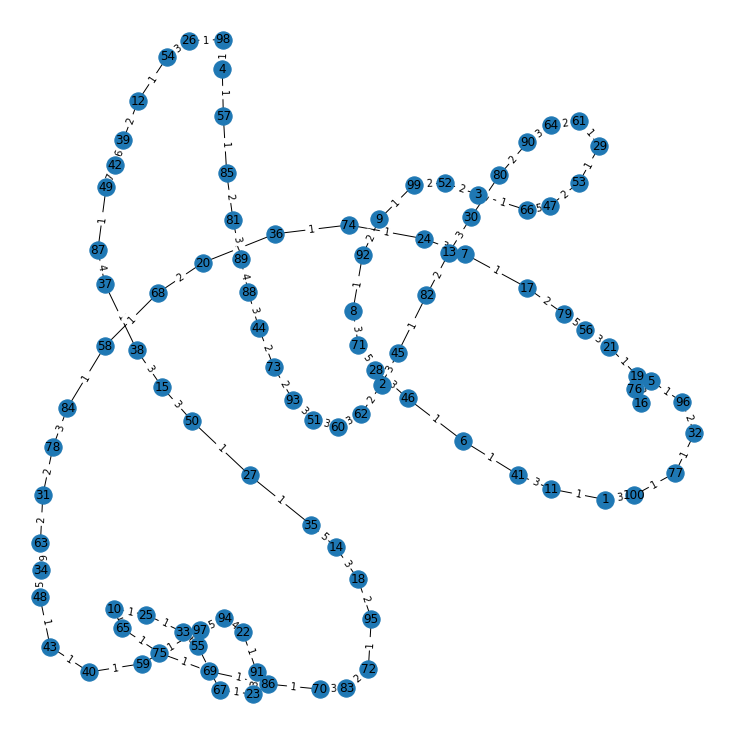

In [15]:
solution = mdl.solve(log_output=True)
#print(mdl.export_to_string()) 
#valor_objetivo = mdl.solution.get_objective_value()
x=solution.get_value_dict(x, keep_zeros=True, precision=1)
graphic(x,C,N)

#print("Objective Value:",valor_objetivo)